<a href="https://colab.research.google.com/github/dymbe/unet-reproducibility-project/blob/master/Reproducibility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Original website of the paper](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)

First we declare all of our imports and classes for data processing. We implement data augmenation in the form of rotations and elastic transforms, and we pad the input image, using mirror padding, as described in the paper, to achieve an input of desired size, which for output of 512x512 is 700x700. We then load our data set into a dataloader, further splitting the data into train and validation sets.

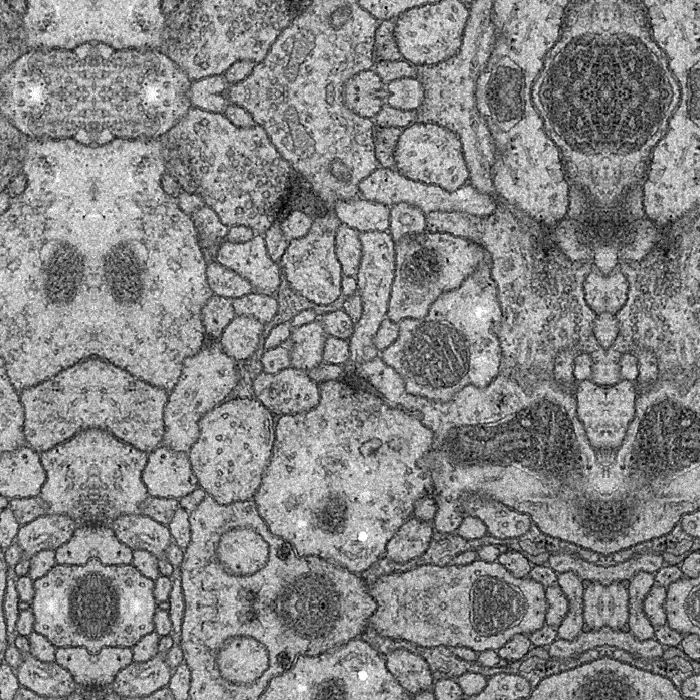

In [0]:
from collections import defaultdict
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import random
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from time import time
import matplotlib.pyplot as plt
from torchsummary import summary

image = Image.open('train-volume.tif')
image_label = Image.open('train-labels.tif')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 1

class Rotate(object):
  def __call__(self, sample):
    img, label = sample['image'], sample['label']
    angle = random.randint(0,3)*90
    img = img.rotate(angle)
    label = label.rotate(angle)
    return {'image': img, 'label': label}


def elastic_transform(image, alpha=1000, sigma=10, spline_order=1, mode='nearest', random_state=np.random):
    image = np.array(image)
    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) #* alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) #* alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = [np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))]
    result = np.empty_like(image)
    result[:, :] = map_coordinates(
        image[:, :], indices, order=spline_order, mode=mode
    ).reshape(shape)
    result = Image.fromarray(result)
    return result


class ElasticTransform(object):
    def __call__(self, sample):
        img, label = sample['image'], sample['label']

        # Seed must be between 0 and 2^32 - 1
        seed = np.random.randint((2 ** 32) - 1)
        img = elastic_transform(img, random_state=np.random.RandomState(seed))
        label = elastic_transform(label, random_state=np.random.RandomState(seed))

        return {'image': img, 'label': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        # swap color axis because DID NOT DO THIS BECAUSE ONLY 1 CHANNEL
        # numpy image: H x W x C
        # torch image: C X H X W
        np_img = np.array(image) / (255)
        np_label = np.array(label) / (255)

        return {'image': torch.unsqueeze(torch.from_numpy(np_img).float(),0) ,
                'label': torch.unsqueeze(torch.from_numpy(np_label).float(),0) }

class MirrorPadding(object):
    def __call__(self, sample):
        image = sample['image']
        padded_img = np.pad(image, pad_width=(700-512)//2, mode="symmetric")
        sample['image'] = padded_img
        return sample

class CellDataset(Dataset):
    def __init__(self, indices=None, transform=None):
        self.transform = transform
        self.indices = indices

    def __len__(self):
        if self.indices is not None:
            return len(self.indices)
        else:
            return image.n_frames

    def __getitem__(self, index):
        if self.indices is not None:
            index = self.indices[index]

        image.seek(index)
        image_label.seek(index)
        img = image
        img_label = image_label

        sample = {'image': img, 'label': img_label}
        sample_t = self.transform(sample)

        return sample_t

trans = transforms.Compose([Rotate(),
                            ElasticTransform(),
                            MirrorPadding(),
                            ToTensor()])

train_indices = random.sample(range(0, image.n_frames), int(0.8 * image.n_frames))
val_indices = [i for i in range(0, image.n_frames) if i not in train_indices]

train_data = CellDataset(indices=train_indices, transform=trans)
val_data = CellDataset(indices=val_indices, transform=trans)

dataloaders = {
    'train': DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=0)
}

This cell is the actual architecture. We define a module for double convolution followed by a ReLU, as this operation occurs on many layers of the network. We then define a module for a step on the downward path, which is a double convolution followed by a max-pool operation. Similarly, a module for a step on the upward path, which is upconvolution, followed by a copy and crop operation, and finally a double convolution. We then assemble all the modules in the network, and finally crop the output to obtain a 512x512 predicted image, which is the same size as the given label.



In [0]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def weights_init(self, m):
        if type(m) in [nn.Conv2d]:
          in_channels = m.in_channels
          nn.init.normal_(m.weight, mean=0.0, std=math.sqrt(2/(9*in_channels)))

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=0),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.double_conv.apply(self.weights_init)

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)  
        #We concatenate the upsampled vector with 
        #the corresponding vector from the downward path
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])
        crop_x2 =  x2[:,
                      :, 
                      diffY : (diffY + x1.size()[2]), 
                      diffX : (diffX + x1.size()[3])]
        
        x = torch.cat([crop_x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


"""Main Class"""
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256) 
        self.down3 = Down(256, 512) 
        self.down4 = Down(512, 1024) 
        self.up1 = Up(1024, 512, bilinear) 
        self.up2 = Up(512, 256, bilinear) 
        self.up3 = Up(256, 128, bilinear) 
        self.up4 = Up(128, 64, bilinear) 
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        logits = logits[:,:,2 : logits.size()[2]-2,2 : logits.size()[3]-2]
        return logits

In this cell we run the training procedure, collecting training and validation loss for plotting.

training


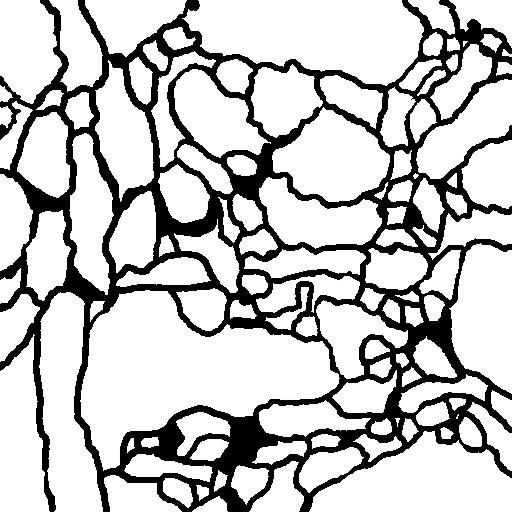

target target  tensor(0.7003, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.6964, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.6882, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.6800, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.6661, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.6547, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.6315, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.6112, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.5871, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.5752, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.5627, device='cuda:0', gra

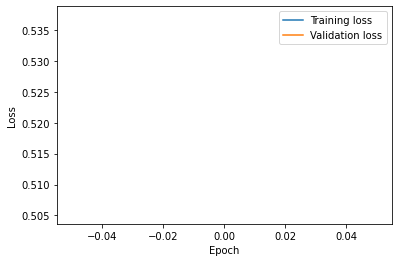

target target  tensor(0.5124, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.5107, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.5000, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4964, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4898, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4861, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4857, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4805, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4705, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4646, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4603, device='cuda:0', gra

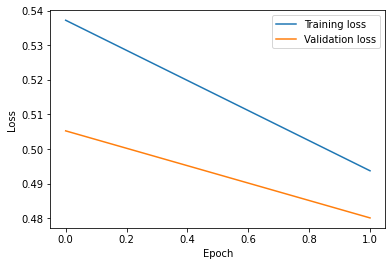

target target  tensor(0.4582, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4501, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4461, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4346, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4309, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4220, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4243, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4282, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4375, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4478, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4522, device='cuda:0', gra

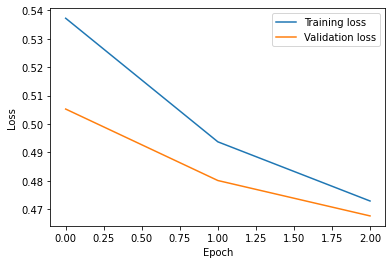

target target  tensor(0.4280, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4259, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4211, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4175, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4207, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4160, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4234, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4255, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4305, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4334, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4403, device='cuda:0', gra

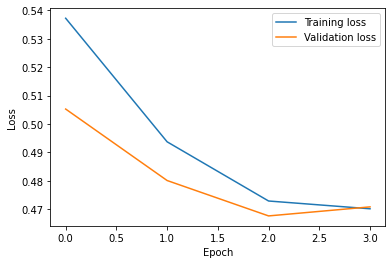

target target  tensor(0.4292, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4381, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4416, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4433, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4440, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4386, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4454, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4442, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4420, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4333, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4342, device='cuda:0', gra

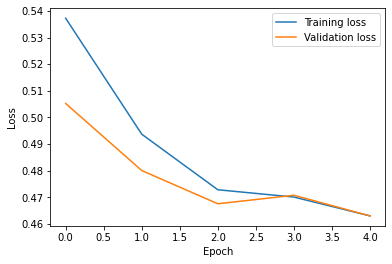

target target  tensor(0.4205, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4215, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4268, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4328, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4328, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4310, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4353, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4312, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4317, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4292, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4359, device='cuda:0', gra

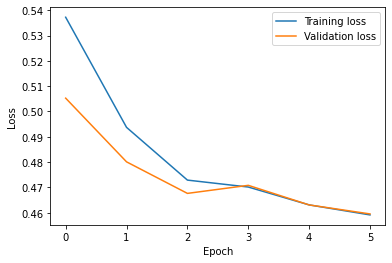

target target  tensor(0.4113, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4169, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4210, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4306, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4341, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4343, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4346, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4456, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4417, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4443, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4367, device='cuda:0', gra

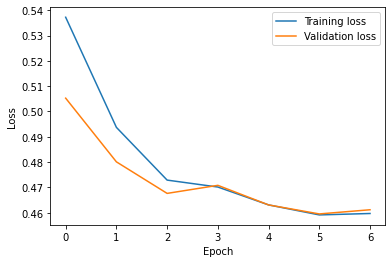

target target  tensor(0.4264, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4221, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4174, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4193, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4246, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4178, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4191, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4218, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4250, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4201, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4305, device='cuda:0', gra

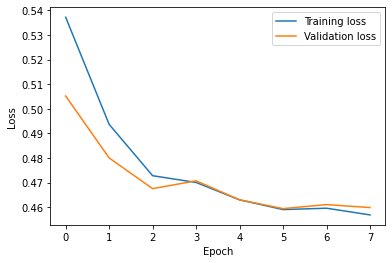

target target  tensor(0.4223, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4254, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4248, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4301, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4270, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4214, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4169, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4166, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4252, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4226, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4214, device='cuda:0', gra

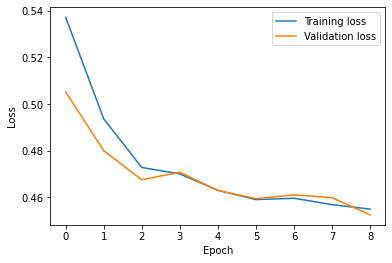

target target  tensor(0.4183, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4261, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4276, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4251, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4245, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4319, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4256, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4252, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4229, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4261, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4227, device='cuda:0', gra

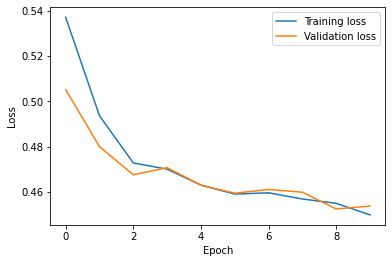

target target  tensor(0.4230, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4167, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4293, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4210, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4291, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4264, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4233, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4303, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4209, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4237, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4295, device='cuda:0', gra

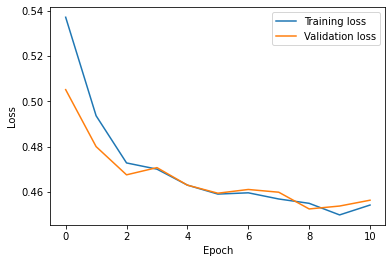

target target  tensor(0.4226, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4268, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4270, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4301, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4306, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4266, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4281, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4279, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4310, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4327, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4313, device='cuda:0', gra

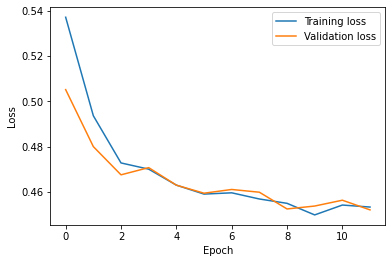

target target  tensor(0.4142, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4241, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4205, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4189, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4226, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4263, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4188, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4228, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4196, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4131, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4120, device='cuda:0', gra

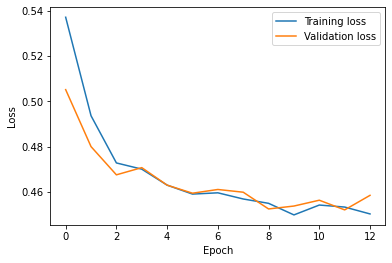

target target  tensor(0.4356, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4339, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4262, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4241, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4199, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4234, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4264, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4248, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4255, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4275, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4282, device='cuda:0', gra

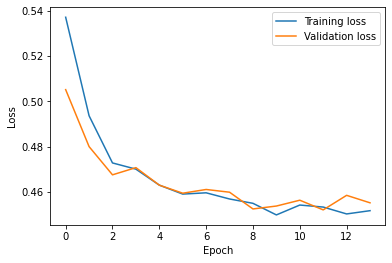

target target  tensor(0.4148, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4236, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4207, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4301, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4245, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4289, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4328, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4358, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4371, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4272, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4263, device='cuda:0', gra

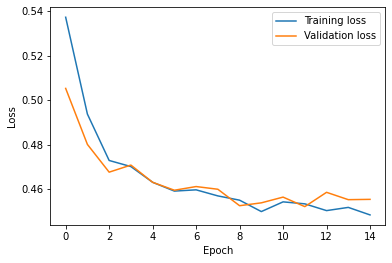

target target  tensor(0.4175, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4197, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4275, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4237, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4262, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4235, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4215, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4198, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4228, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4212, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4313, device='cuda:0', gra

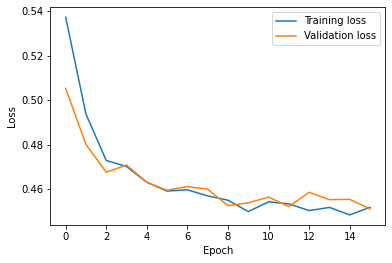

target target  tensor(0.4253, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4203, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4223, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4215, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4319, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4173, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4175, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4166, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4187, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4161, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4172, device='cuda:0', gra

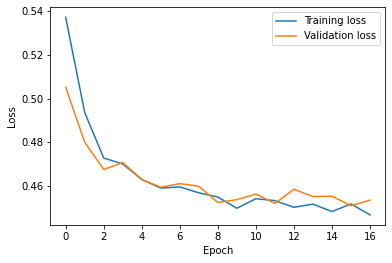

target target  tensor(0.4248, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4212, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4171, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4227, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4259, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4245, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4263, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4163, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4157, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4186, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4200, device='cuda:0', gra

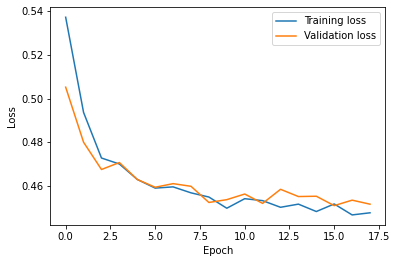

target target  tensor(0.4166, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4181, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4144, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4188, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4170, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4096, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4095, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4070, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4140, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4141, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4076, device='cuda:0', gra

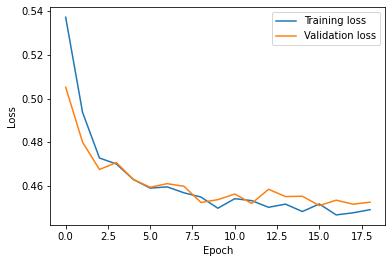

target target  tensor(0.4319, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4217, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4256, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4222, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4263, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4213, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4153, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4259, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4168, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4201, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4177, device='cuda:0', gra

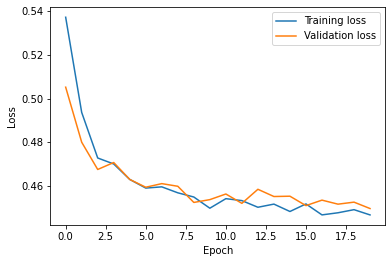

target target  tensor(0.4182, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4268, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4225, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4248, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4290, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4251, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4170, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4186, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4268, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4219, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4190, device='cuda:0', gra

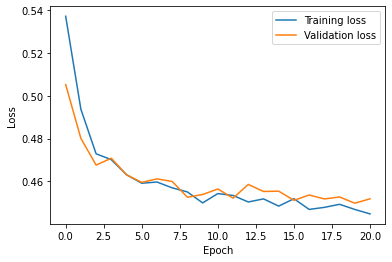

target target  tensor(0.4216, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4137, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4255, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4256, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4216, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4298, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4206, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4250, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4216, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4232, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4198, device='cuda:0', gra

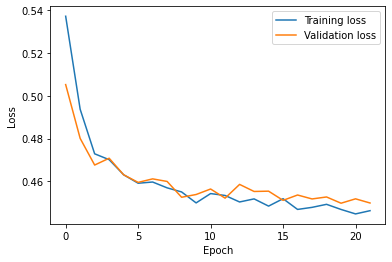

target target  tensor(0.4155, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4127, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4271, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4171, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4173, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4241, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4231, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4169, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4230, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4138, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4125, device='cuda:0', gra

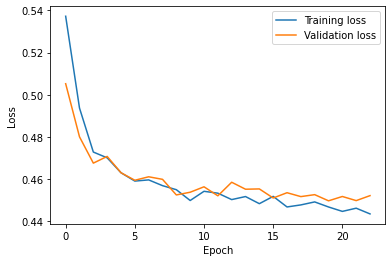

target target  tensor(0.4251, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4159, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4175, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4275, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4179, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4139, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4240, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4135, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4167, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4142, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4180, device='cuda:0', gra

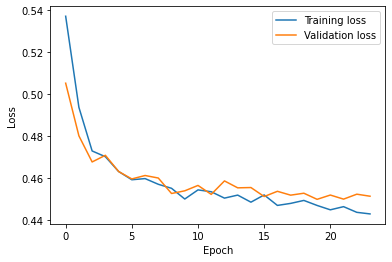

target target  tensor(0.4276, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4182, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4223, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4172, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4310, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4190, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4200, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4228, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4220, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4288, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4199, device='cuda:0', gra

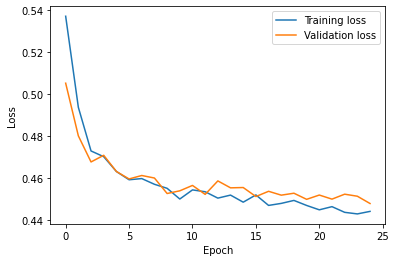

target target  tensor(0.4180, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4166, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4141, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4092, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4132, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4154, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4170, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4201, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4081, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4183, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4098, device='cuda:0', gra

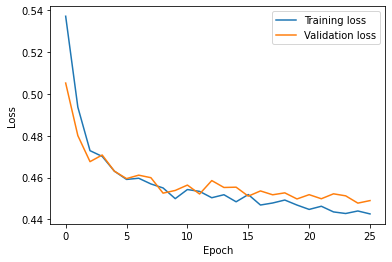

target target  tensor(0.4257, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4251, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4208, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4165, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4210, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4306, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4278, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4182, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4190, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4284, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4186, device='cuda:0', gra

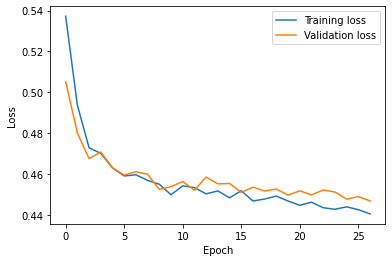

target target  tensor(0.4180, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4227, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4153, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4209, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4213, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4207, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4101, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4118, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4141, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4223, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4269, device='cuda:0', gra

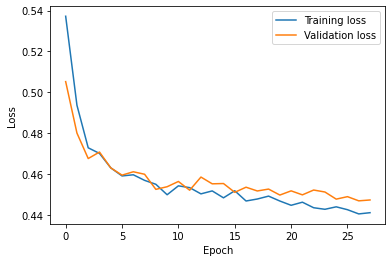

target target  tensor(0.4128, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4094, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4094, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4118, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4211, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4193, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4270, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4329, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4305, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4257, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4280, device='cuda:0', gra

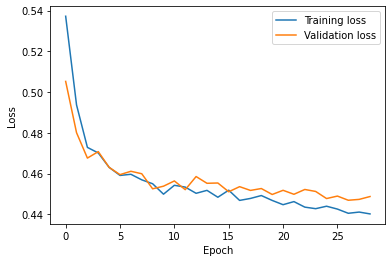

target target  tensor(0.4178, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4134, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4123, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4254, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4130, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4256, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4142, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4171, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4136, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4248, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4159, device='cuda:0', gra

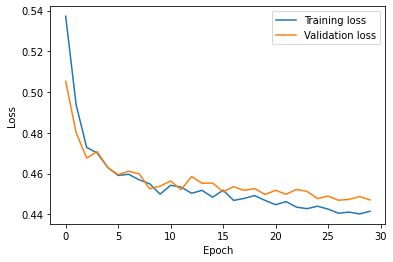

target target  tensor(0.4111, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4173, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4143, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4184, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4205, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4099, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4123, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4138, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4146, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4259, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4190, device='cuda:0', gra

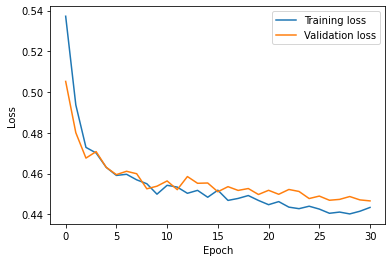

target target  tensor(0.4157, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4227, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4222, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4129, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4106, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4144, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4261, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4113, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4130, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4124, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4135, device='cuda:0', gra

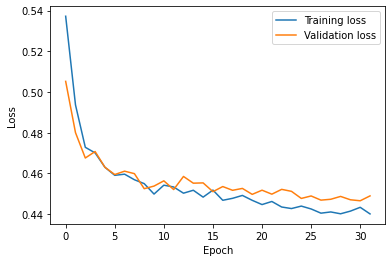

target target  tensor(0.4133, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4151, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4188, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4257, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4109, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4115, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4131, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4170, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4088, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4118, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4111, device='cuda:0', gra

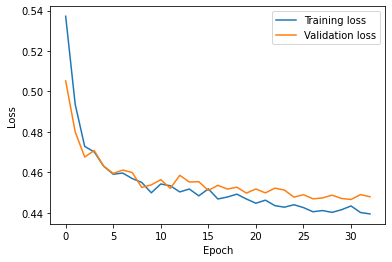

target target  tensor(0.4144, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4248, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4129, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4159, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4098, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4217, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4123, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4224, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4104, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4196, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4172, device='cuda:0', gra

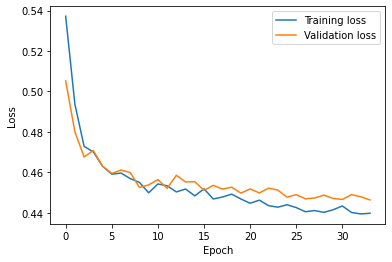

target target  tensor(0.4252, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4153, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4221, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4280, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4245, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4139, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4163, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4136, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4104, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4072, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4058, device='cuda:0', gra

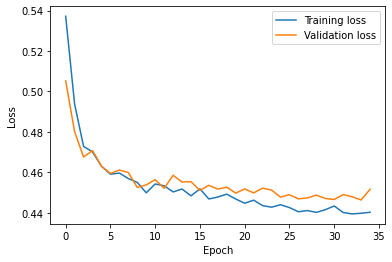

target target  tensor(0.4176, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4131, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4198, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4141, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4269, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4140, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4133, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4130, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4090, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4188, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4243, device='cuda:0', gra

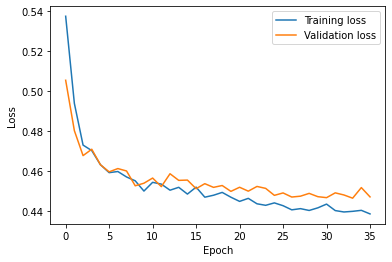

target target  tensor(0.4123, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4136, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4144, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4171, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4130, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4222, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4113, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4244, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4135, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4170, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4102, device='cuda:0', gra

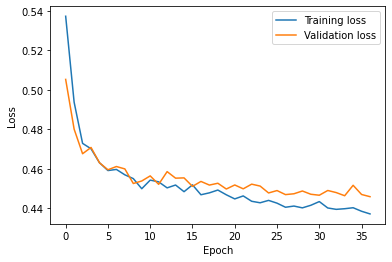

target target  tensor(0.4229, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4209, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4256, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4145, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4239, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4285, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4163, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4185, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4139, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4128, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4218, device='cuda:0', gra

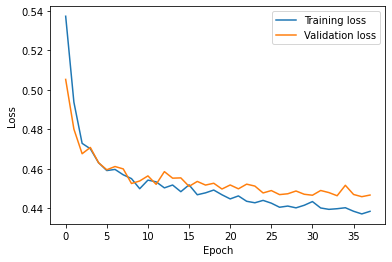

target target  tensor(0.4144, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4087, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4063, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4127, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4036, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4129, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4163, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4078, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4070, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4185, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4240, device='cuda:0', gra

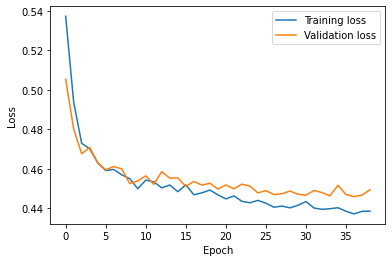

target target  tensor(0.4246, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4256, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4153, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4167, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4283, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4209, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4145, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4165, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4167, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4224, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4123, device='cuda:0', gra

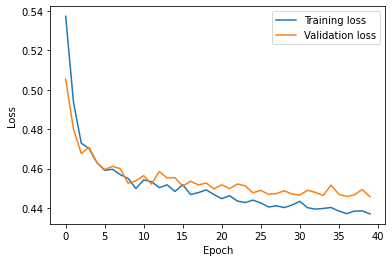

target target  tensor(0.4199, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4130, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4222, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4146, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4142, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4218, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4278, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4149, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4207, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4134, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4139, device='cuda:0', gra

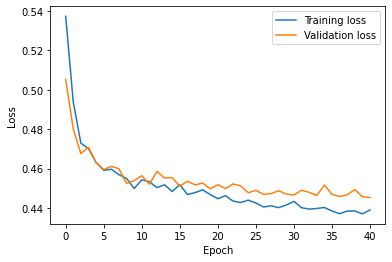

target target  tensor(0.4161, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4290, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4265, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4128, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4180, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4128, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4166, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4105, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4229, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4247, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4179, device='cuda:0', gra

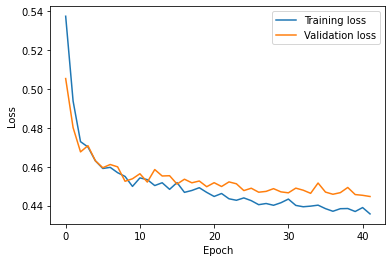

target target  tensor(0.4127, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4096, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4069, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4151, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4097, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4040, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4127, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4180, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4061, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4246, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4131, device='cuda:0', gra

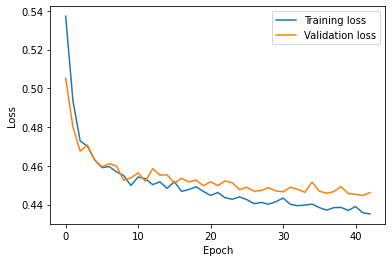

target target  tensor(0.4193, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4178, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4264, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4175, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4120, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4151, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4273, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4168, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4108, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4230, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4103, device='cuda:0', gra

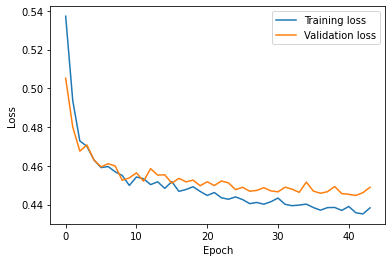

target target  tensor(0.4126, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4091, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4177, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4138, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4098, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4221, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4225, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4106, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4240, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4128, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4173, device='cuda:0', gra

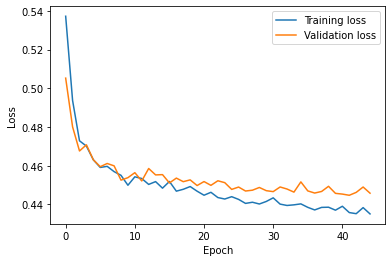

target target  tensor(0.4179, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4139, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4117, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4115, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4252, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4105, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4135, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4100, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4161, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4045, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4165, device='cuda:0', gra

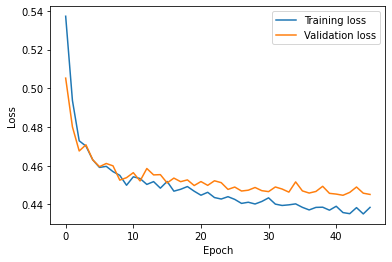

target target  tensor(0.4185, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4120, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4159, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4249, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4268, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4142, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4276, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4139, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4202, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4166, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4256, device='cuda:0', gra

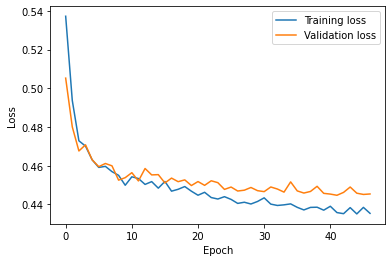

target target  tensor(0.4100, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4069, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4046, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4091, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4216, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4179, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4067, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4121, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4085, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4156, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4088, device='cuda:0', gra

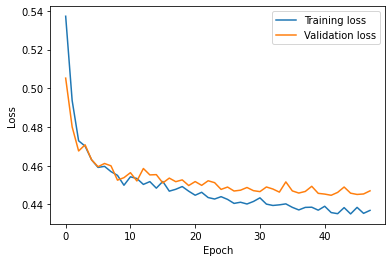

target target  tensor(0.4115, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4241, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4156, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4233, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4068, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4125, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4099, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4104, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4169, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4176, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4054, device='cuda:0', gra

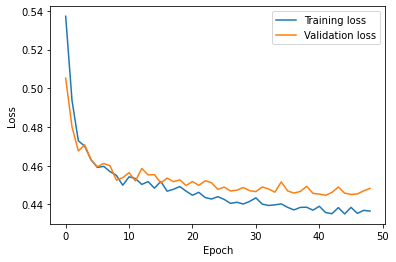

target target  tensor(0.4184, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4122, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4127, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4162, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4311, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4137, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4281, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4155, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4102, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4088, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4213, device='cuda:0', gra

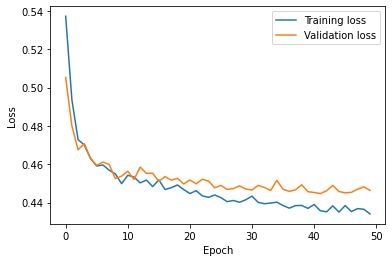

target target  tensor(0.4249, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4228, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4154, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4091, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4090, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4124, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4091, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4079, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4085, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4098, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4031, device='cuda:0', gra

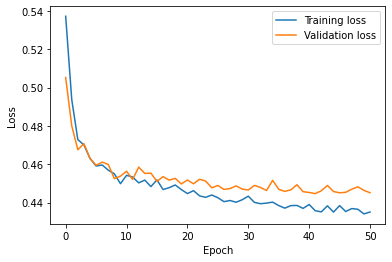

target target  tensor(0.4153, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4113, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4105, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4217, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4080, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4043, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4076, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4160, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4053, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4101, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4170, device='cuda:0', gra

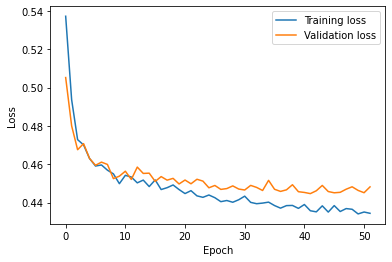

target target  tensor(0.4141, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4136, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4121, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4125, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4070, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4192, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4117, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4228, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4195, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4094, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4126, device='cuda:0', gra

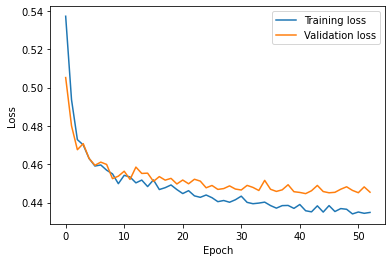

target target  tensor(0.4085, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4224, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4082, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4069, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4064, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4187, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4145, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4080, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4071, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4075, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4064, device='cuda:0', gra

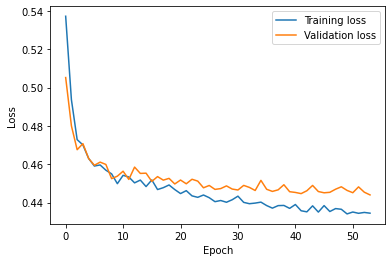

target target  tensor(0.4143, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4156, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4108, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4142, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4053, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4077, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4096, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4145, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4157, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4228, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4102, device='cuda:0', gra

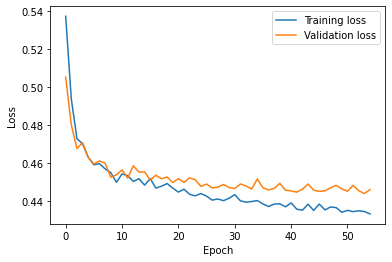

target target  tensor(0.4063, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4107, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4147, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4221, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4127, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4138, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4190, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4097, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4226, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4230, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4143, device='cuda:0', gra

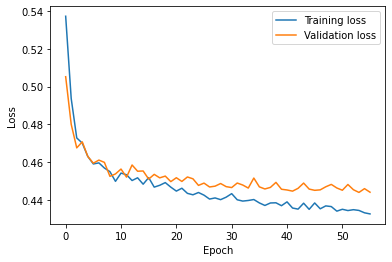

target target  tensor(0.4063, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4054, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4044, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4068, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4088, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4192, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4118, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4106, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4099, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4191, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4147, device='cuda:0', gra

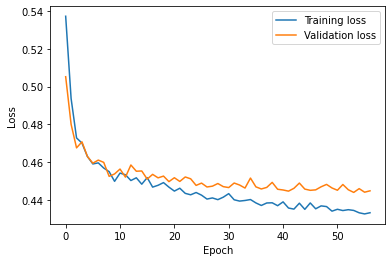

target target  tensor(0.4103, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4103, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4102, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4060, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4115, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4204, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4141, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4129, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4185, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4054, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4126, device='cuda:0', gra

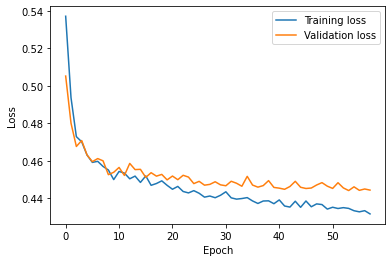

target target  tensor(0.4229, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4067, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4082, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4106, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4221, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4127, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4234, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4248, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4141, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4215, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4112, device='cuda:0', gra

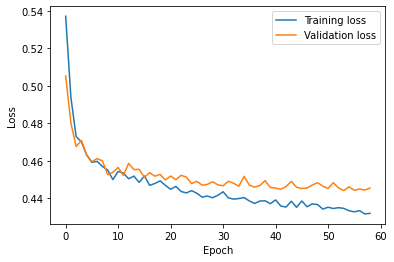

target target  tensor(0.4078, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4193, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4232, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4160, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4180, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4029, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4067, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4151, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4138, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4050, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4137, device='cuda:0', gra

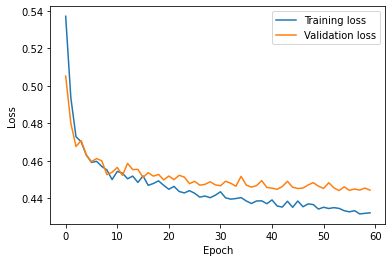

target target  tensor(0.4106, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4104, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4120, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4037, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4039, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4026, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4020, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4157, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4114, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4199, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4119, device='cuda:0', gra

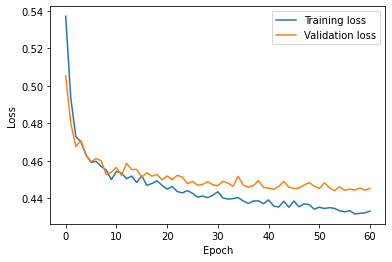

target target  tensor(0.4167, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4073, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4115, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4104, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4059, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4190, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4105, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4039, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4169, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4267, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4207, device='cuda:0', gra

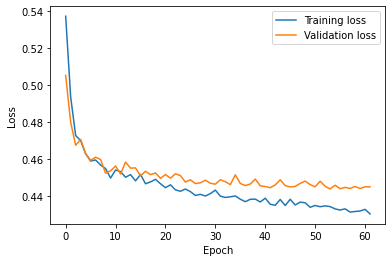

target target  tensor(0.4189, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4043, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4085, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4113, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4184, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4169, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4271, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4067, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4261, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4246, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4171, device='cuda:0', gra

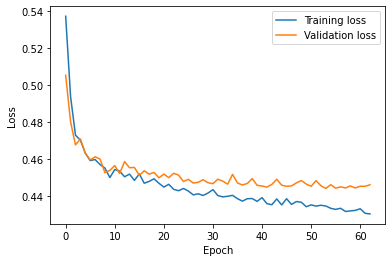

target target  tensor(0.4163, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4208, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4242, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4126, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4188, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4078, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4140, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4088, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4236, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4244, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4083, device='cuda:0', gra

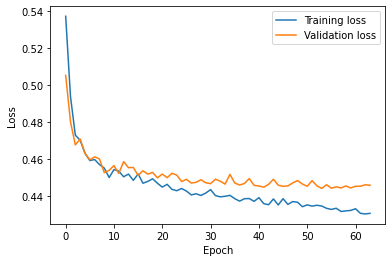

target target  tensor(0.4069, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4249, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4062, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4086, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4129, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4104, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4073, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4209, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4221, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4058, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4208, device='cuda:0', gra

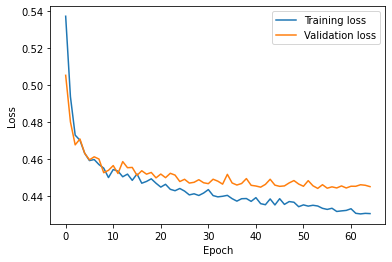

target target  tensor(0.4083, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4116, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4083, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4115, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4135, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4072, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4028, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4156, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4081, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4073, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4128, device='cuda:0', gra

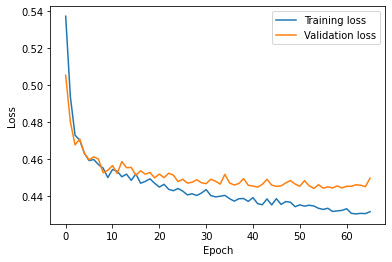

target target  tensor(0.4094, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4052, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4225, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4022, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4109, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4024, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4182, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4129, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4179, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4091, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4075, device='cuda:0', gra

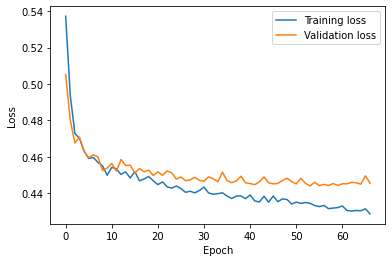

target target  tensor(0.4107, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4110, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4161, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4078, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4039, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4044, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4210, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4285, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4081, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4134, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4080, device='cuda:0', gra

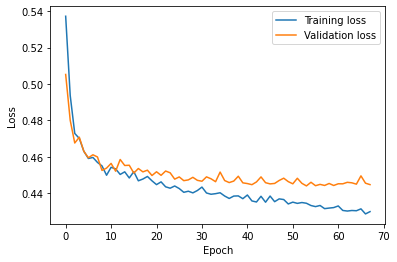

target target  tensor(0.4060, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4087, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4263, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4212, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4054, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4129, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4053, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4212, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4086, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4124, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4194, device='cuda:0', gra

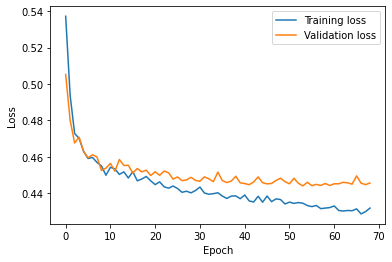

target target  tensor(0.4131, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4056, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4196, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4278, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4185, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4201, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4206, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4229, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4066, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4067, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4025, device='cuda:0', gra

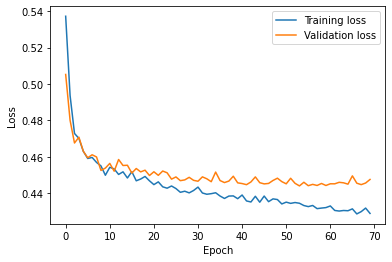

target target  tensor(0.4131, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4080, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4080, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4160, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4008, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4138, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4069, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4197, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4194, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4201, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4252, device='cuda:0', gra

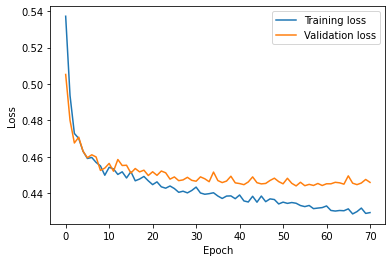

target target  tensor(0.4119, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4182, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4153, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4211, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4057, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4076, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4303, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4221, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4079, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4080, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4212, device='cuda:0', gra

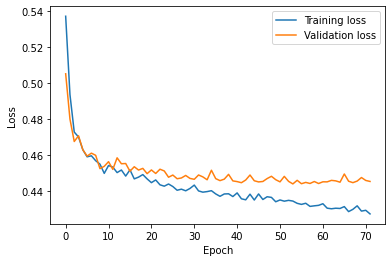

target target  tensor(0.4177, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4090, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4220, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4253, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4070, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4123, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4086, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4198, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4121, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4138, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4201, device='cuda:0', gra

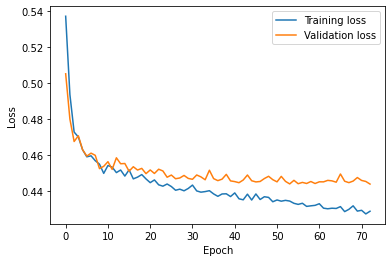

target target  tensor(0.4029, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4029, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4022, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4060, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4020, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4163, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4125, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4136, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4034, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4138, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4269, device='cuda:0', gra

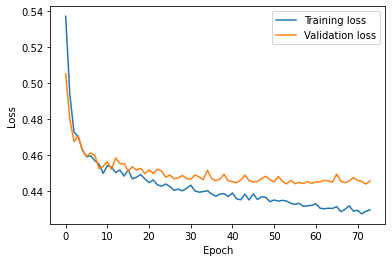

target target  tensor(0.4193, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4207, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4075, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4045, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4185, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4040, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4181, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4015, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4010, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4053, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4226, device='cuda:0', gra

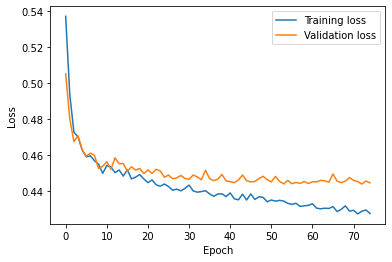

target target  tensor(0.4034, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4276, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4062, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4099, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4141, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4144, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4201, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4093, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4031, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4107, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4002, device='cuda:0', gra

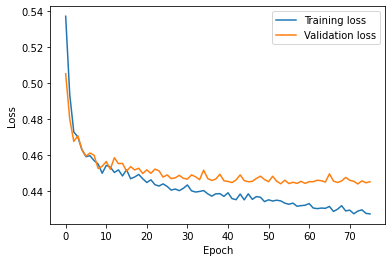

target target  tensor(0.4080, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4132, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4075, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4058, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4099, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4158, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4089, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4278, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4097, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4106, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4081, device='cuda:0', gra

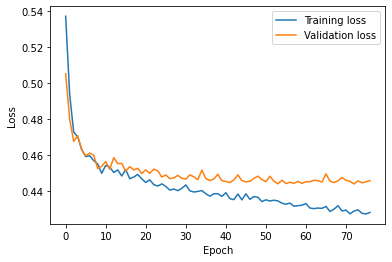

target target  tensor(0.4079, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4026, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4099, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4063, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4076, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4025, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4191, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4084, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4076, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4042, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4154, device='cuda:0', gra

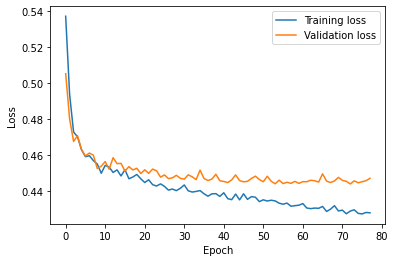

target target  tensor(0.4216, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4076, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4043, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4150, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4147, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4076, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4241, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4178, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4122, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4068, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4017, device='cuda:0', gra

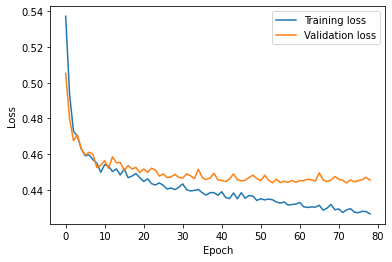

target target  tensor(0.4057, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4179, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4014, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4168, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4194, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4149, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4001, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4043, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4098, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4057, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4106, device='cuda:0', gra

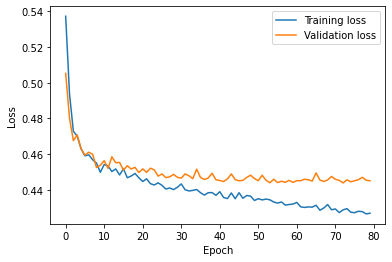

target target  tensor(0.4089, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4194, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4101, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4158, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4261, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4225, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4090, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4128, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4072, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4041, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4023, device='cuda:0', gra

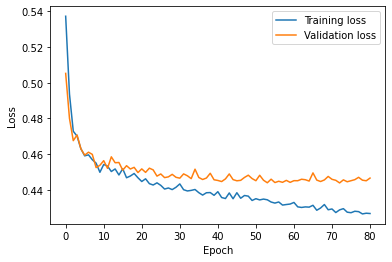

target target  tensor(0.4046, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4099, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4172, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4173, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4253, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4092, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4222, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4213, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4109, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4060, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4156, device='cuda:0', gra

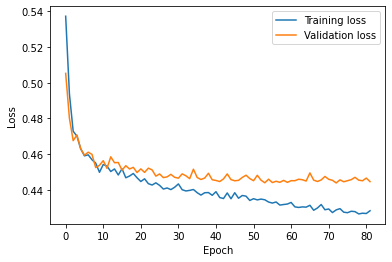

target target  tensor(0.4205, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4050, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4158, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4148, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4071, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4033, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3965, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4181, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4179, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4202, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4054, device='cuda:0', gra

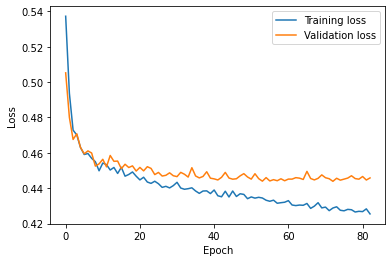

target target  tensor(0.4075, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4122, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4085, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4068, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4120, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4120, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4107, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4088, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4199, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4038, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4196, device='cuda:0', gra

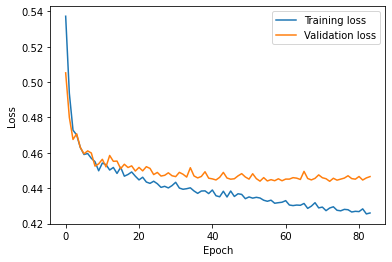

target target  tensor(0.4107, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4242, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4077, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4196, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4214, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4149, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4043, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4033, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4189, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4207, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4054, device='cuda:0', gra

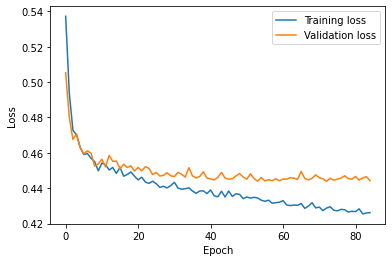

target target  tensor(0.4196, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4192, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4092, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4265, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4180, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4242, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4068, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4034, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4040, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4120, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4078, device='cuda:0', gra

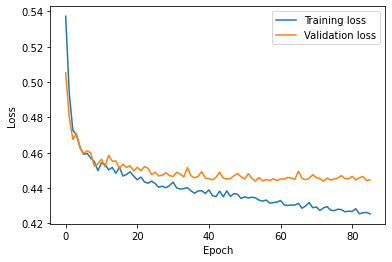

target target  tensor(0.4152, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4171, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4040, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4255, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4118, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4140, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4064, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4112, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4087, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4177, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4013, device='cuda:0', gra

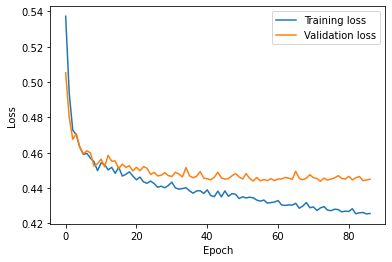

target target  tensor(0.4072, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4179, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4067, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4002, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4261, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4025, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4123, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4045, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4056, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4032, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4216, device='cuda:0', gra

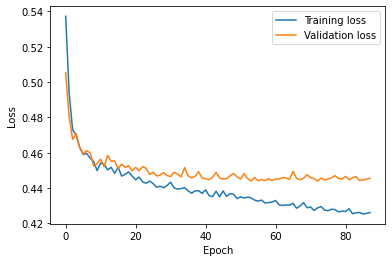

target target  tensor(0.4276, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4237, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4108, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4084, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4148, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4067, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4129, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4220, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4047, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4187, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4215, device='cuda:0', gra

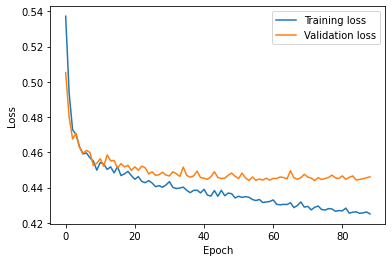

target target  tensor(0.4214, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4150, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4093, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3999, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4186, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4123, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4209, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4041, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4284, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4033, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4138, device='cuda:0', gra

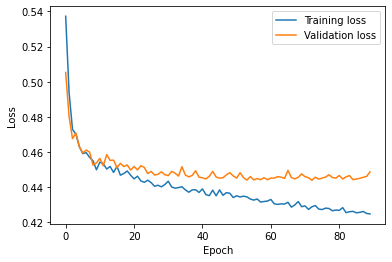

target target  tensor(0.4056, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4265, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4041, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4083, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4003, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4181, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4204, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4020, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4093, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4017, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4137, device='cuda:0', gra

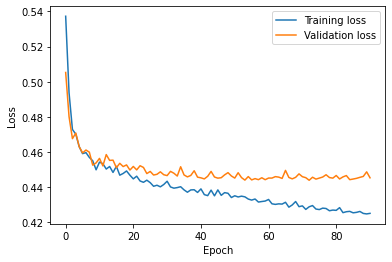

target target  tensor(0.4056, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4031, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4183, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4139, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4081, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4083, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4275, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3984, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4059, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4001, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4002, device='cuda:0', gra

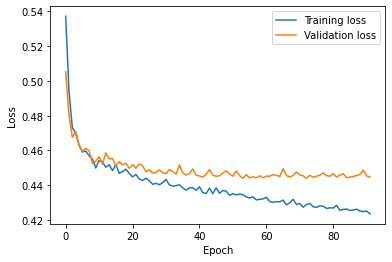

target target  tensor(0.4169, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4090, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4009, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4034, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4149, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4174, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4039, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4163, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4083, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4030, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4078, device='cuda:0', gra

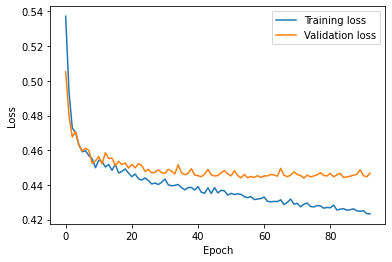

target target  tensor(0.4259, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4061, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4004, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4017, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4197, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4187, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4164, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3999, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4041, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4025, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4164, device='cuda:0', gra

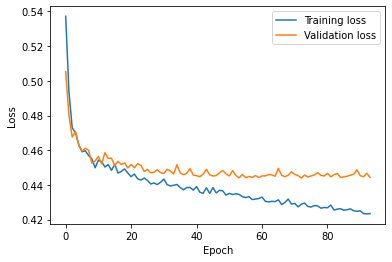

target target  tensor(0.4008, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4024, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4001, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4172, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4054, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4164, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4152, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4041, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4029, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4177, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4047, device='cuda:0', gra

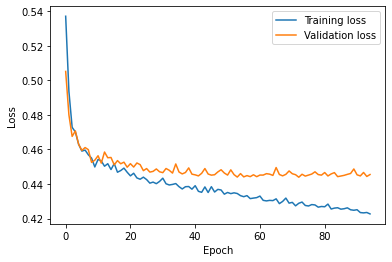

target target  tensor(0.4006, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4002, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4171, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4083, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4026, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4176, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4173, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4147, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4057, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4073, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4088, device='cuda:0', gra

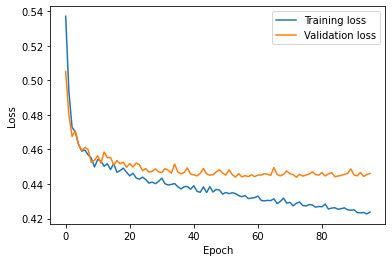

target target  tensor(0.4035, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4090, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4166, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3967, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4048, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4047, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4010, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4140, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4166, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4055, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4190, device='cuda:0', gra

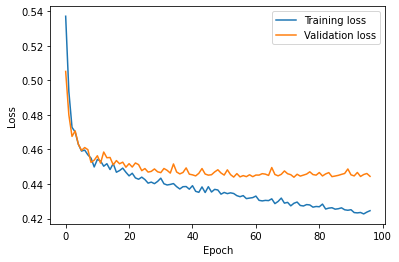

target target  tensor(0.4254, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4300, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4205, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4131, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4079, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4248, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4125, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4036, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4215, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4028, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4134, device='cuda:0', gra

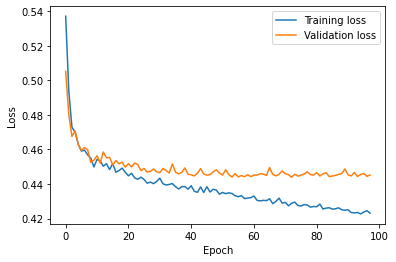

target target  tensor(0.4029, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3975, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4049, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4169, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4052, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4236, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4025, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4214, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4059, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4119, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4196, device='cuda:0', gra

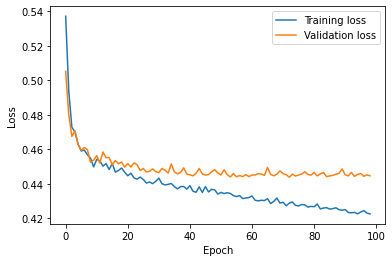

target target  tensor(0.4162, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4088, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4042, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4027, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4037, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4012, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4206, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4163, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4258, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4187, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4220, device='cuda:0', gra

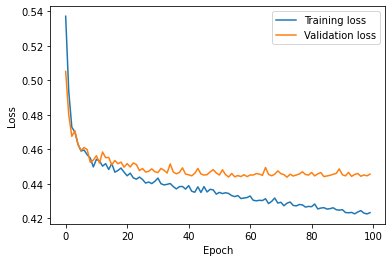

target target  tensor(0.4011, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3990, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4055, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4268, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4178, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4104, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4236, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4161, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4047, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4011, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4087, device='cuda:0', gra

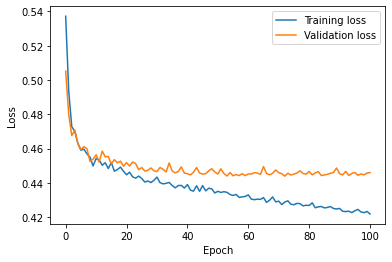

target target  tensor(0.4080, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4022, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4188, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4006, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4102, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4092, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4195, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4063, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4022, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4197, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4016, device='cuda:0', gra

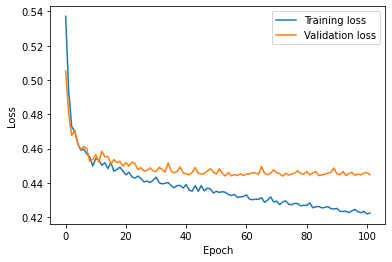

target target  tensor(0.4091, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4182, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4154, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4002, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4010, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3953, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4014, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3994, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3967, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4148, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4251, device='cuda:0', gra

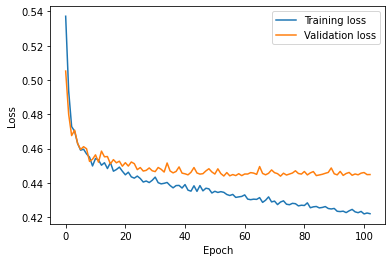

target target  tensor(0.3989, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4107, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4200, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4040, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4069, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4243, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4209, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4114, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4057, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4174, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4036, device='cuda:0', gra

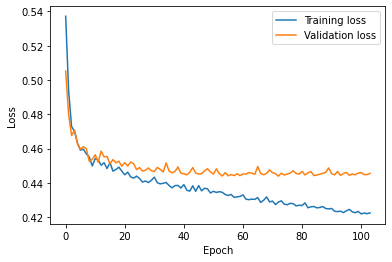

target target  tensor(0.4081, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4034, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4065, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4057, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4241, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4084, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3966, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4063, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3946, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4018, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3970, device='cuda:0', gra

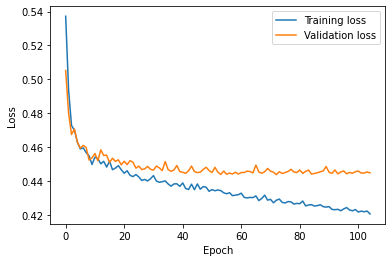

target target  tensor(0.4180, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3995, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3966, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4013, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4124, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4009, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4246, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4013, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3984, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3937, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4139, device='cuda:0', gra

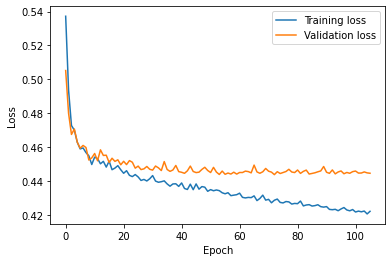

target target  tensor(0.4070, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4008, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3996, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4009, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3971, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4065, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3955, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4056, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4133, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4145, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4022, device='cuda:0', gra

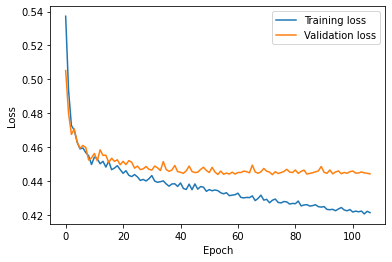

target target  tensor(0.4048, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4064, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4188, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4145, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4000, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4057, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4069, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3958, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4080, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4166, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4093, device='cuda:0', gra

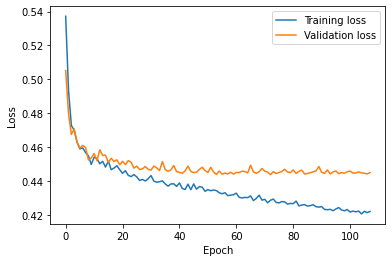

target target  tensor(0.4131, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4216, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4107, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4278, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4004, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4191, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4023, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4028, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4087, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4171, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3983, device='cuda:0', gra

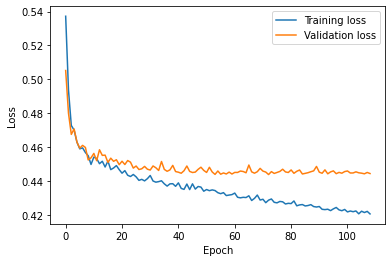

target target  tensor(0.4251, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4074, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4001, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4074, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4159, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4001, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4022, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4060, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3949, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4002, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4176, device='cuda:0', gra

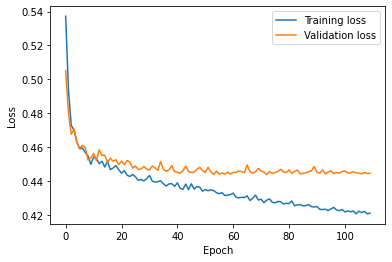

target target  tensor(0.4009, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4272, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4004, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4254, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4028, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4036, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4049, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4041, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3968, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4053, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4146, device='cuda:0', gra

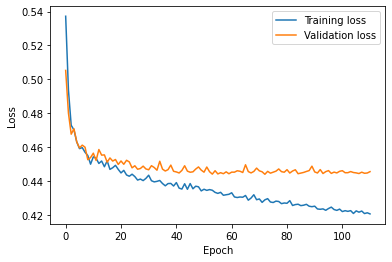

target target  tensor(0.3980, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4026, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4020, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3956, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3932, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3991, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4100, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3983, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4028, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4257, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4178, device='cuda:0', gra

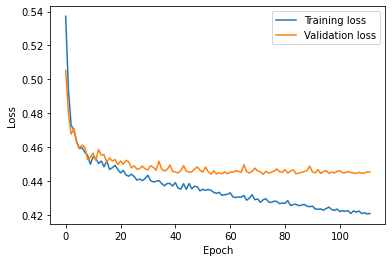

target target  tensor(0.4247, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4004, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4043, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4056, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4006, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4178, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4088, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4222, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3990, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4135, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4066, device='cuda:0', gra

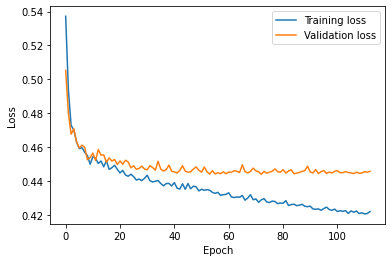

target target  tensor(0.4268, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4166, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4190, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4045, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4007, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4098, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4080, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4164, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4087, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4006, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4139, device='cuda:0', gra

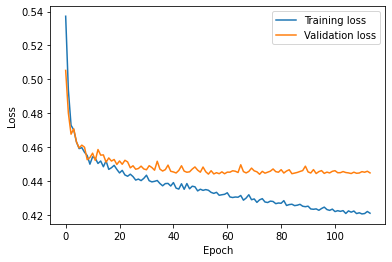

target target  tensor(0.4080, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4065, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3974, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4225, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4004, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4283, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3992, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4000, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4077, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4197, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4005, device='cuda:0', gra

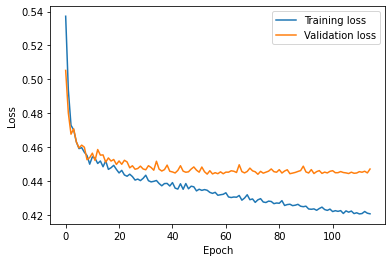

target target  tensor(0.3990, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4026, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3975, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4008, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4160, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4040, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4088, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4047, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3994, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3986, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4019, device='cuda:0', gra

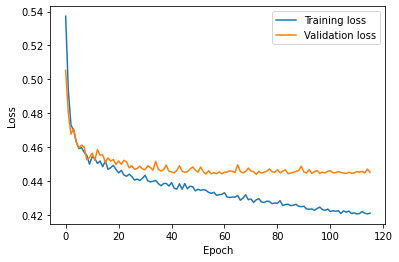

target target  tensor(0.3956, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4160, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4085, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4037, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4067, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4120, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4156, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4122, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4024, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4205, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4185, device='cuda:0', gra

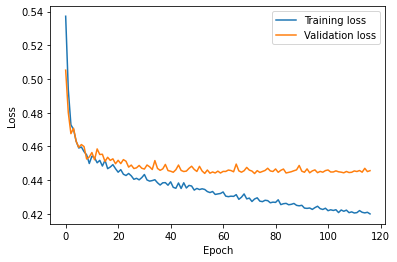

target target  tensor(0.4159, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3973, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3999, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3976, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4286, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4007, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4104, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4244, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4046, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4077, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4197, device='cuda:0', gra

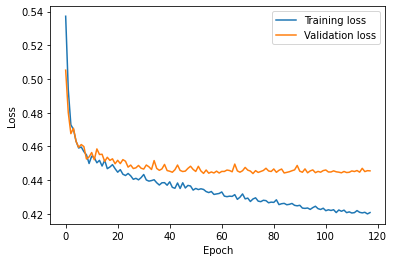

target target  tensor(0.4159, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4085, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4004, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4101, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4222, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4009, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4090, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4184, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3991, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4041, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4079, device='cuda:0', gra

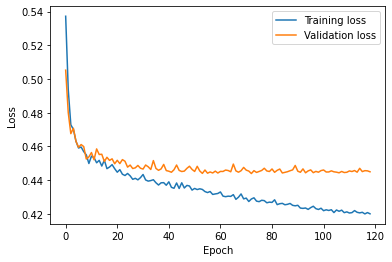

target target  tensor(0.4246, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4015, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4186, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4029, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3986, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4086, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4159, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4084, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4198, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4068, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4117, device='cuda:0', gra

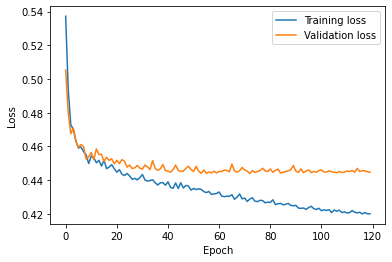

target target  tensor(0.4010, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4139, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4039, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4011, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4037, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4147, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4015, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4297, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4004, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4033, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4220, device='cuda:0', gra

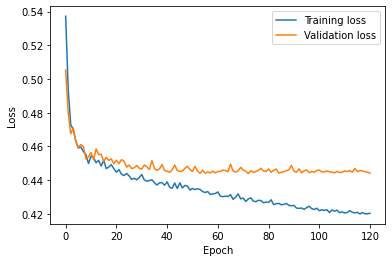

target target  tensor(0.4028, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3996, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4259, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4207, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4183, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4074, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3981, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4125, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3994, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4114, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4137, device='cuda:0', gra

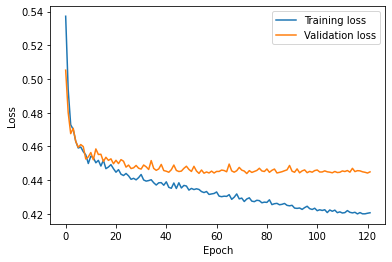

target target  tensor(0.4186, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4154, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4170, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4022, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4147, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3982, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4131, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4237, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3969, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3992, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3978, device='cuda:0', gra

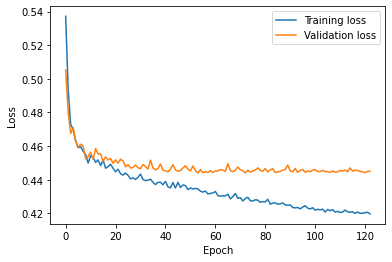

target target  tensor(0.3997, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4074, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4030, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4029, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4093, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4183, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4005, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3975, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4131, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4021, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3976, device='cuda:0', gra

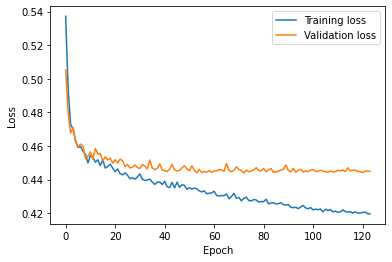

target target  tensor(0.4141, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4069, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3948, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4072, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3928, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4119, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4030, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4054, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3998, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4026, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4183, device='cuda:0', gra

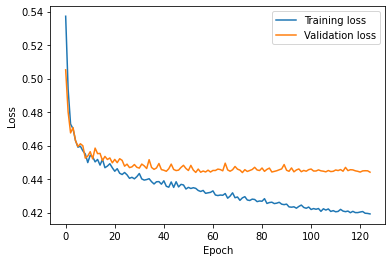

target target  tensor(0.4275, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4093, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3975, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4028, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3996, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4039, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4060, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4046, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4163, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4125, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4018, device='cuda:0', gra

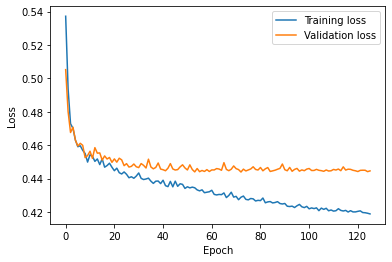

target target  tensor(0.4237, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4155, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4012, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4028, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4022, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3963, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3990, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3950, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3952, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4064, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4043, device='cuda:0', gra

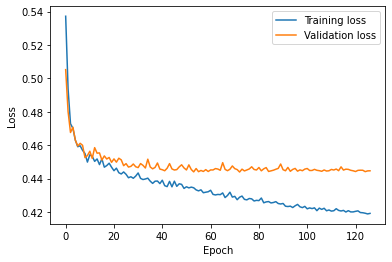

target target  tensor(0.4070, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4003, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4107, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4197, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4195, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4120, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4287, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4082, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4187, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4057, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4193, device='cuda:0', gra

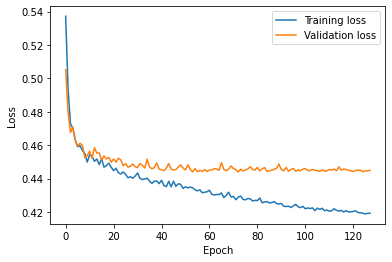

target target  tensor(0.4120, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4254, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4057, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4162, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4022, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4168, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3953, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4228, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4031, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3984, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4183, device='cuda:0', gra

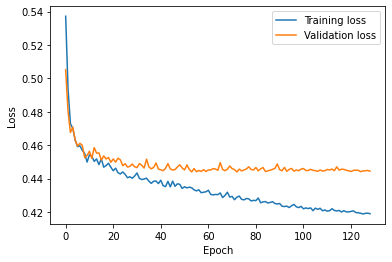

target target  tensor(0.3998, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3982, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4075, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4104, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3985, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4023, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4091, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3974, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4195, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4042, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4023, device='cuda:0', gra

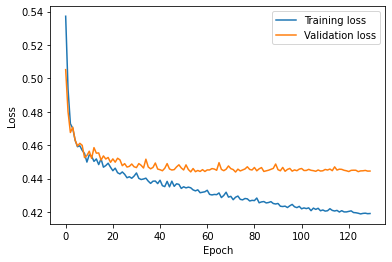

target target  tensor(0.3989, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4032, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3943, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4007, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4160, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4059, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4205, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4106, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3977, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4254, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4054, device='cuda:0', gra

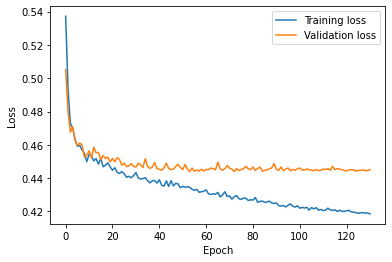

target target  tensor(0.3963, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3957, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3951, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4006, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4010, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3936, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3982, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4136, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4063, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4175, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4302, device='cuda:0', gra

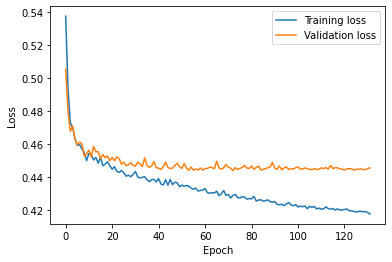

target target  tensor(0.4269, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3948, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4154, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4101, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4217, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4168, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3987, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4085, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4017, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3989, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4078, device='cuda:0', gra

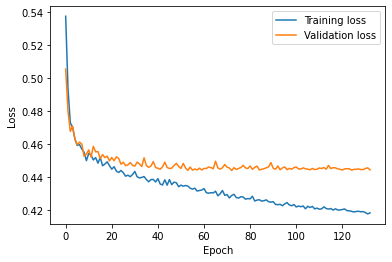

target target  tensor(0.4058, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3984, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4029, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4180, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4210, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4093, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4049, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4166, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4026, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4266, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4098, device='cuda:0', gra

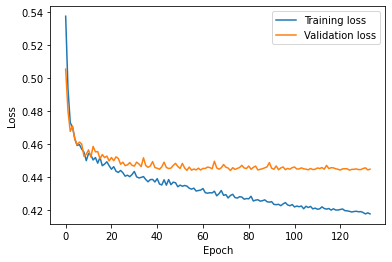

target target  tensor(0.3988, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4031, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4052, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4166, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3970, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4232, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4002, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4290, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4092, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4187, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4033, device='cuda:0', gra

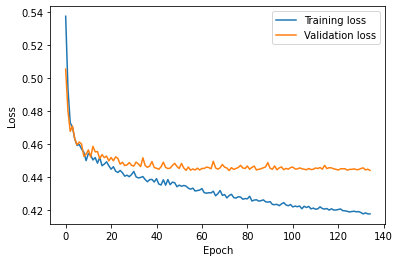

target target  tensor(0.3947, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4020, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4132, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3954, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4187, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3981, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4145, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3955, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4150, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4129, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4081, device='cuda:0', gra

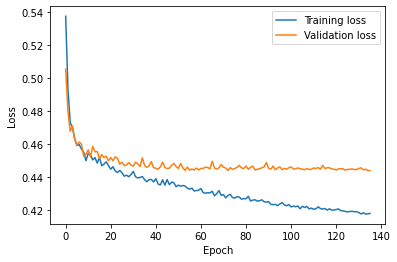

target target  tensor(0.4096, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3963, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3984, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3983, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4076, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4036, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3985, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3962, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4134, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4256, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4022, device='cuda:0', gra

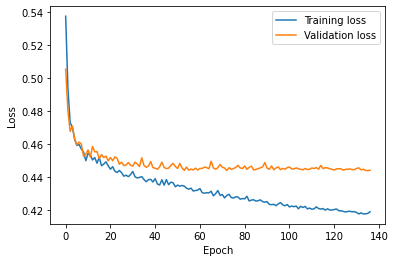

target target  tensor(0.4004, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4006, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3985, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4161, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3954, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3996, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3952, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4238, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4171, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4269, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4099, device='cuda:0', gra

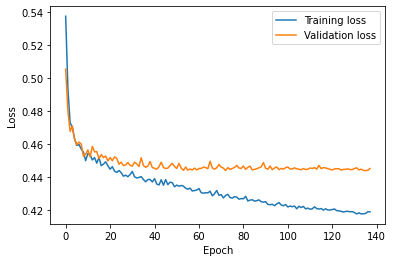

target target  tensor(0.4110, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4023, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3943, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4133, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4015, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4018, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3958, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3978, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4139, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3972, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3963, device='cuda:0', gra

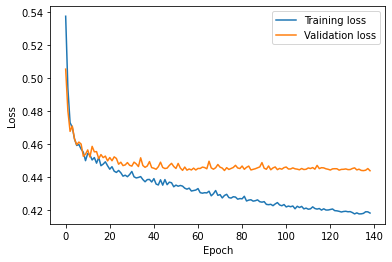

target target  tensor(0.4059, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3949, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4147, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4004, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4018, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3996, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4137, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4200, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4060, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3988, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3983, device='cuda:0', gra

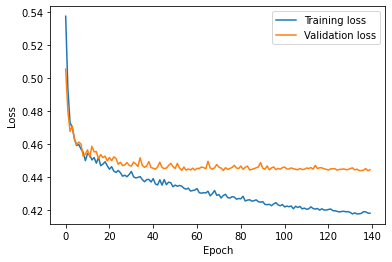

target target  tensor(0.4007, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3980, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4068, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4080, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3980, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4027, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4045, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4185, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3942, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4260, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3938, device='cuda:0', gra

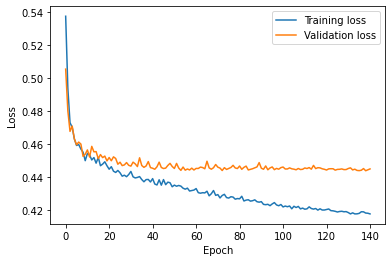

target target  tensor(0.4037, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3957, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3936, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3985, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4003, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4036, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3976, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3935, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4128, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4136, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4046, device='cuda:0', gra

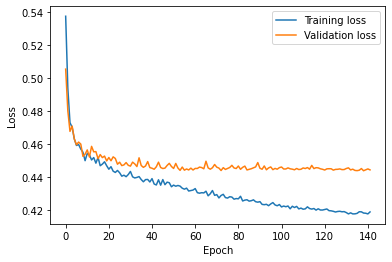

target target  tensor(0.4070, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4175, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4189, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4030, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4174, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4022, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4027, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4030, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4046, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4127, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4034, device='cuda:0', gra

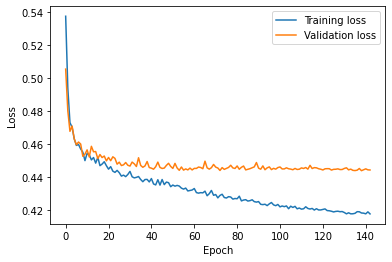

target target  tensor(0.4063, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3996, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3962, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4126, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3918, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4037, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3987, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4021, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3974, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4152, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4106, device='cuda:0', gra

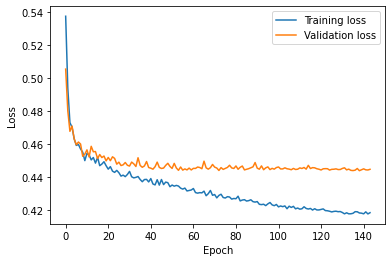

target target  tensor(0.4007, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4149, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4025, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4048, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3990, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4191, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4016, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4111, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4163, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4134, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4168, device='cuda:0', gra

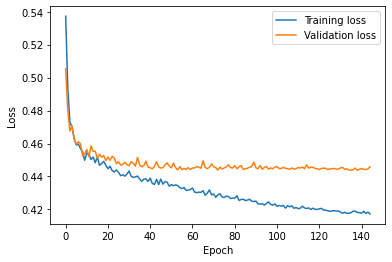

target target  tensor(0.4007, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4069, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3957, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4172, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3991, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4084, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4011, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4037, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4000, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4127, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3964, device='cuda:0', gra

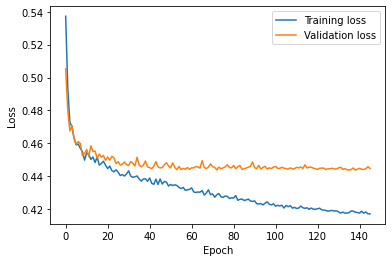

target target  tensor(0.4025, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3974, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4164, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4006, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4044, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4156, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4258, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3933, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3974, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4051, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3987, device='cuda:0', gra

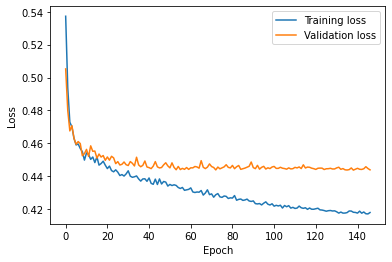

target target  tensor(0.3941, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4044, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3954, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4062, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4116, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4034, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4161, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4030, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4221, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4089, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4024, device='cuda:0', gra

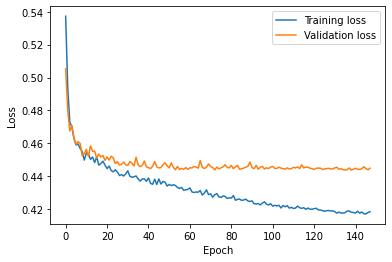

target target  tensor(0.4093, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4176, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4039, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4144, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4199, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4015, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4171, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4023, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4091, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4003, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3921, device='cuda:0', gra

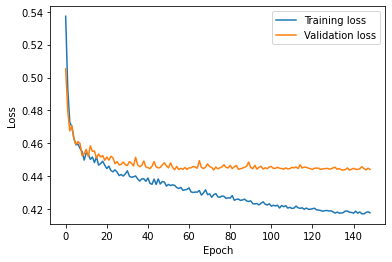

target target  tensor(0.4181, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4192, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4021, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4041, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3968, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3962, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3961, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4028, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3934, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4101, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4228, device='cuda:0', gra

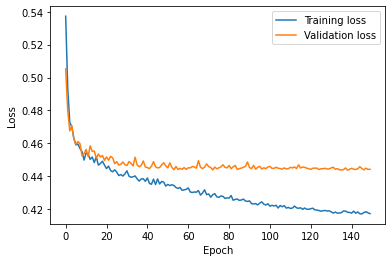

target target  tensor(0.4182, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4154, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4029, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4067, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3943, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3943, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4061, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4040, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4112, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4069, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4180, device='cuda:0', gra

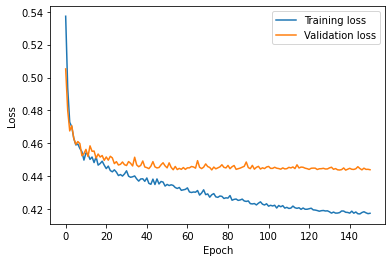

target target  tensor(0.4055, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4163, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4106, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4071, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4026, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4219, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4151, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3937, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4164, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4023, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3960, device='cuda:0', gra

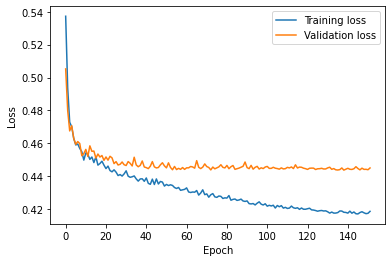

target target  tensor(0.4287, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4030, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4163, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3995, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4164, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4076, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4185, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4039, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3983, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4121, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4075, device='cuda:0', gra

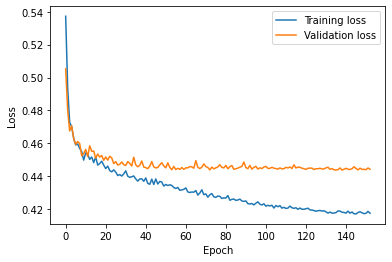

target target  tensor(0.3916, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3970, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3920, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3954, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4140, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3929, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4112, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4038, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4266, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4085, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4060, device='cuda:0', gra

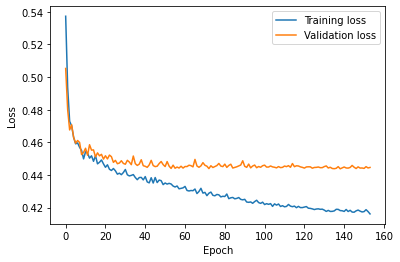

target target  tensor(0.4130, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4061, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3987, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4169, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4165, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4184, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4033, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4249, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4133, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3995, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4011, device='cuda:0', gra

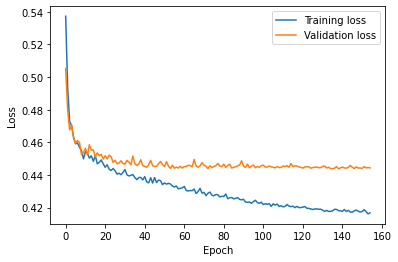

target target  tensor(0.4170, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4070, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4273, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3950, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4040, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4139, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4223, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3980, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4005, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4064, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4112, device='cuda:0', gra

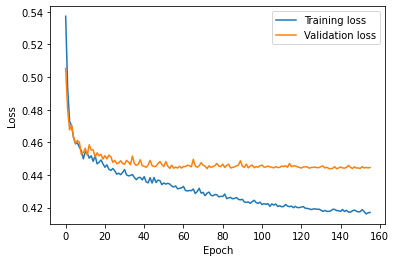

target target  tensor(0.4080, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3998, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4033, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4027, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4163, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3976, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3987, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4074, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4084, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4049, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4015, device='cuda:0', gra

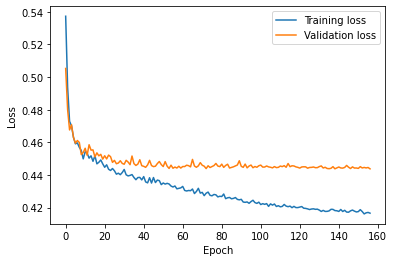

target target  tensor(0.4052, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3972, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4102, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3982, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4126, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3949, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3943, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3982, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3985, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3949, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4013, device='cuda:0', gra

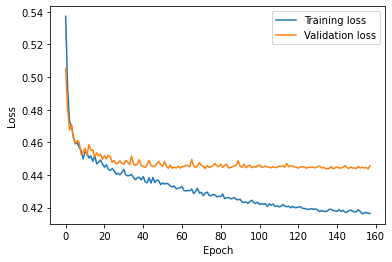

target target  tensor(0.4091, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3972, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4167, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4081, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3981, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4307, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4012, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4076, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4174, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3984, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4210, device='cuda:0', gra

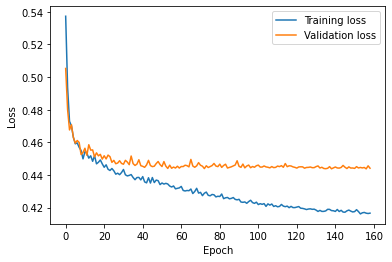

target target  tensor(0.3929, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3993, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4256, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4069, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4054, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4190, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4022, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4063, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4030, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4019, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3939, device='cuda:0', gra

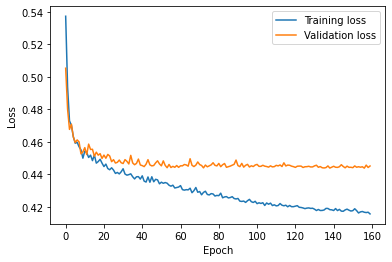

target target  tensor(0.4125, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4268, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4030, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4129, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3949, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3985, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3953, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4129, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4041, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4236, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4053, device='cuda:0', gra

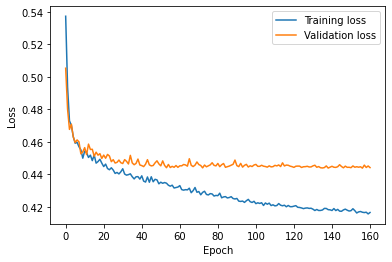

target target  tensor(0.4220, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3971, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4116, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4159, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4067, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4181, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4046, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4176, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3995, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3961, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4072, device='cuda:0', gra

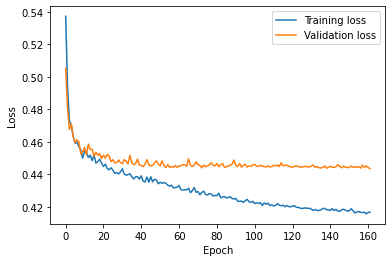

target target  tensor(0.4007, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4053, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4069, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4162, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3920, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3993, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4065, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4041, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4002, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3926, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4200, device='cuda:0', gra

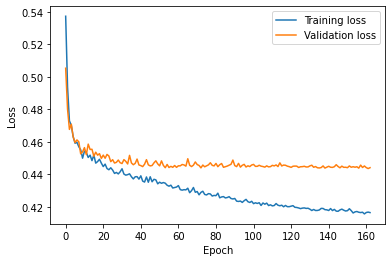

target target  tensor(0.4274, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3965, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4057, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3946, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4179, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4010, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3962, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4165, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4154, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4067, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4217, device='cuda:0', gra

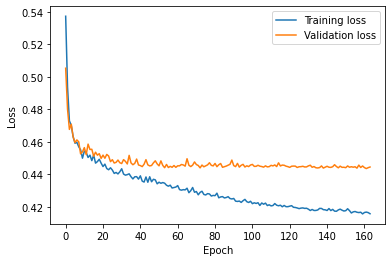

target target  tensor(0.4043, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4157, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3993, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4160, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4025, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4300, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4091, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4120, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3995, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4253, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3953, device='cuda:0', gra

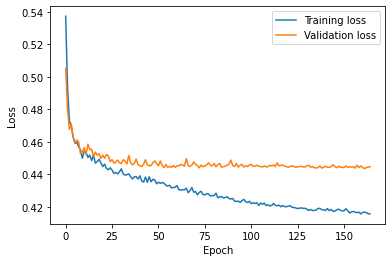

target target  tensor(0.3958, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4136, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4154, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4130, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3916, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4052, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3958, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4043, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3934, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4301, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4014, device='cuda:0', gra

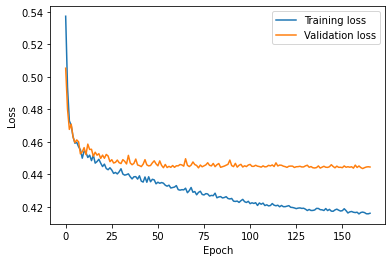

target target  tensor(0.4082, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3995, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4069, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4005, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3967, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4046, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4046, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4189, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4167, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4000, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4056, device='cuda:0', gra

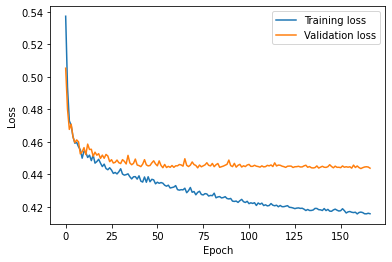

target target  tensor(0.3915, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3996, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4193, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4004, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4052, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4104, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4169, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4032, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3936, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3971, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4291, device='cuda:0', gra

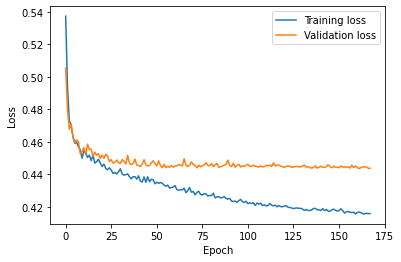

target target  tensor(0.4096, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4163, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4173, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4002, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4172, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4043, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3976, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4017, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4046, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3981, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4057, device='cuda:0', gra

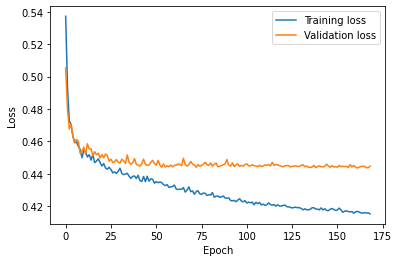

target target  tensor(0.3946, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4129, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4157, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3979, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4056, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3908, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3973, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4112, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3986, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3916, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4071, device='cuda:0', gra

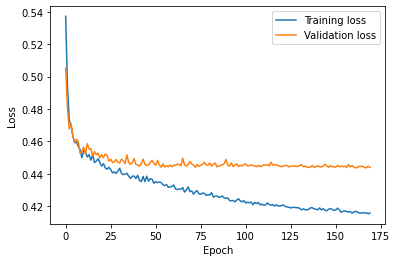

target target  tensor(0.4034, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4116, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4059, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4060, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4170, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4000, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3983, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4091, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4173, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4100, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4164, device='cuda:0', gra

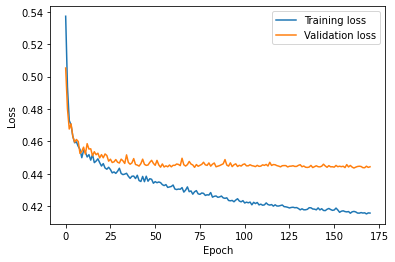

target target  tensor(0.3990, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4013, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4101, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4152, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3994, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4165, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4084, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4070, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3989, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4178, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4036, device='cuda:0', gra

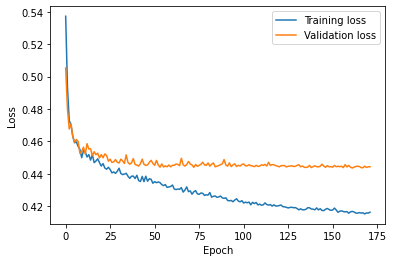

target target  tensor(0.4032, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3984, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4013, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3965, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3994, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4152, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4002, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4029, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3961, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4146, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4118, device='cuda:0', gra

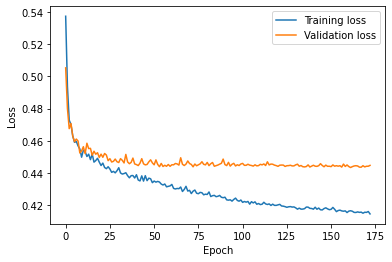

target target  tensor(0.4108, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4268, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4151, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4033, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3992, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3981, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4012, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4092, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4095, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4182, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3919, device='cuda:0', gra

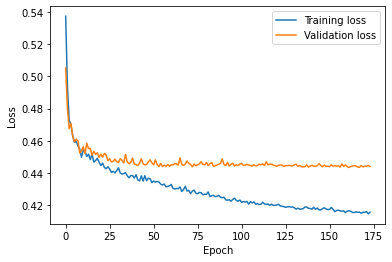

target target  tensor(0.3996, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3918, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4153, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4020, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3946, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3941, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4026, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3923, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4079, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4013, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4086, device='cuda:0', gra

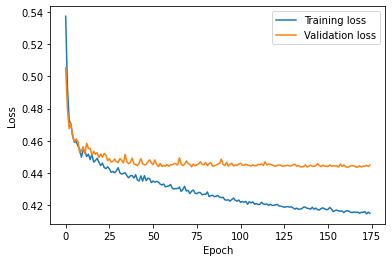

target target  tensor(0.3946, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4142, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3935, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4105, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4039, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4032, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4085, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4116, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4024, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4053, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3970, device='cuda:0', gra

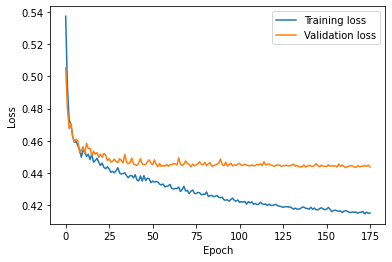

target target  tensor(0.4067, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3926, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4132, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4138, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4028, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4126, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4075, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3977, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3968, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4153, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3972, device='cuda:0', gra

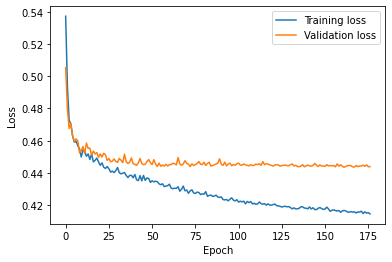

target target  tensor(0.4124, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4046, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3985, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4006, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4203, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4061, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4093, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3992, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4082, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.4026, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
target target  tensor(0.3979, device='cuda:0', gra

In [0]:
#Hyperparameters
lr = 1e-4
weight_decay = 1e-8
momentum = 0.99

def calc_loss(pred, target):
    pred = torch.sigmoid(pred).contiguous()
    target = target.contiguous()
    bce_loss = F.binary_cross_entropy_with_logits(pred, target)
    print("target target ", F.binary_cross_entropy_with_logits(pred, pred))
    return bce_loss.mean()

def train_model(model, epochs):
    print("training")
    train_losses = []
    val_losses = []
    validation_set = [sample for sample in dataloaders['val']]

    val_lbl = validation_set[0]['label']
    val_pil = transforms.ToPILImage()(torch.squeeze(val_lbl, 0))
    display(val_pil)

    for epoch in range(epochs):
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
        train_loss = 0
        time_start = time()
        for batch in dataloaders['train']:
            pred = model(batch['image'].to(device))
            loss = calc_loss(pred, batch['label'].to(device))
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(model.parameters(), 0.1)
            optimizer.step()
        train_loss = train_loss / len(dataloaders['train'])
        train_losses.append(train_loss)

        print("val")
        val_loss = 0
        for batch in validation_set:
            pred = model(batch['image'].to(device))
            loss = calc_loss(pred, batch['label'].to(device))
            val_loss += loss.item()
        val_loss = val_loss / len(validation_set)
        val_losses.append(val_loss)

        time_diff = time() - time_start
        print("epoch: ", epoch)
        print("time elapsed: {:.4f} seconds".format(time_diff))
        print("training loss: ", train_loss)
        print("validation loss: ", val_loss)
    
        x = range(epoch + 1)
        plt.plot(x, train_losses, label="Training loss")
        plt.plot(x, val_losses, label="Validation loss")

        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        # plt.axis([0, epochs, 0, 1])
        plt.legend()
        plt.show()

        pred = model(validation_set[0]['image'].to(device))
        pred_img = torch.squeeze(pred, 0)
        pil_img = transforms.ToPILImage()(pred_img.cpu())

model = UNet(1,1) #1 input, 1 output
model = model.to(device)
summary(model, input_size=(1, 700, 700))
train_model(model, epochs=300)

  

In the final cell, we load the test set into the dataloader and perform the necessary mirror padding to obtain a testing image to feed into the model. We then present the predicted segmentation map.

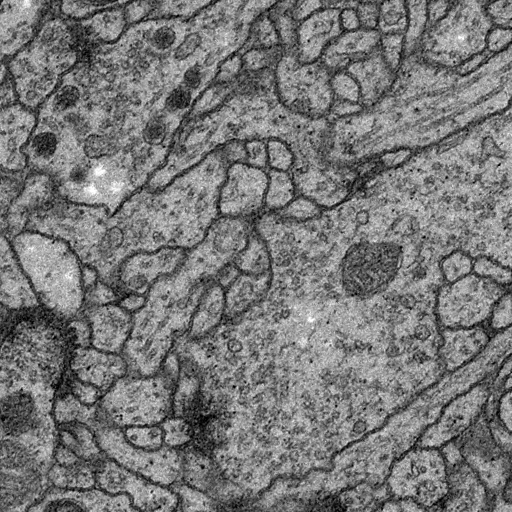

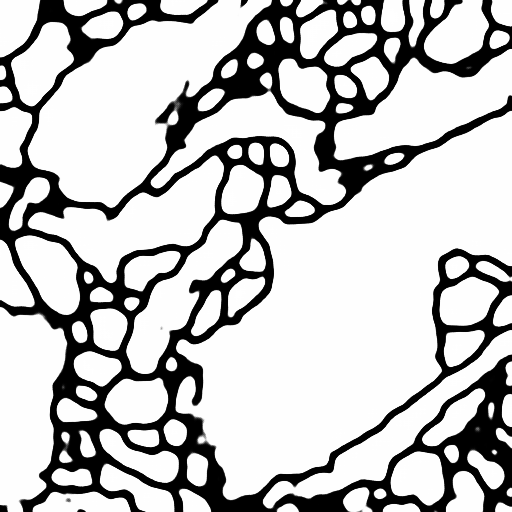

In [0]:
image_t = Image.open('test-volume.tif')
model.cpu()

class ToTensor_img(object):
    def __call__(self, sample):
        image = sample['image']
        np_img = np.array(image) / (255)

        return {'image': torch.unsqueeze(torch.from_numpy(np_img).float(), 0)}

class TestDataset(Dataset):
    def __init__(self):
        self.transform = transforms.Compose([MirrorPadding(),
                                             ToTensor_img()])
  
    def __len__(self):
        return image_t.n_frames
    
    def __getitem__(self, index):
        image_t.seek(index)
        img = image_t
      
        sample = {'image': img}
        sample_t = self.transform(sample)       
        return sample_t

test_data = TestDataset()

dataloaders['test'] = DataLoader(test_data, batch_size=1, shuffle=True, num_workers=0)

sample = next(iter(dataloaders['test']))
img = sample['image']
pred = model(img)
pred = torch.squeeze(torch.sigmoid(pred),0)

pred_img = transforms.ToPILImage()(pred)
img = torch.squeeze(img, 0)
start = (700-512)//2
img = img[:, start : 512 + start, start : 512 + start]
pil_img = transforms.ToPILImage()(img)
display(pil_img)
display(pred_img)